In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import time
from ipynb.fs.defs.functions import translate_name
from ipynb.fs.defs.functions import new_route
from ipynb.fs.defs.functions import get_row
from ipynb.fs.defs.functions import get_column
from ipynb.fs.defs.functions import best_index
from ipynb.fs.defs.functions import find_best_position
from ipynb.fs.defs.functions import cities_list
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import check_cities
from ipynb.fs.defs.functions import random_schedule_day

table=pd.read_csv("../Dati/orari/route.csv", delimiter=";", encoding = "ISO-8859-1")
time_table=pd.read_csv("../Dati/orari/route_time.csv", delimiter=";")
dft = pd.read_csv("../Dati/distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../Dati/distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)

def get_row(df, string):
    return pd.Series(df.index).str.contains(string, case=False)

def get_column(df, string):
    return pd.Series(df.columns).str.contains(string, case=False)


def difference(day, index, index2):
    time = datetime.datetime.strptime(time_table[day][index], '%H:%M')
    time2 = datetime.datetime.strptime(time_table[day][index2], '%H:%M')
    return ((time2-time).seconds)/60

def convert(minutes): 
    hour, minu = divmod(minutes, 60) 
    return "%d:%02d" % (hour, minu) 

In [2]:
data={}
to_write1 = pd.DataFrame(data)
to_write2 = pd.DataFrame(data)
to_write1["lunedi"] = table["lunedi"][:]

In [3]:
#FINAL ALGORITHM (TUE, WED, THU) to extract route
days = ["martedi", "mercoledi", "giovedi"]

for day in days:
    start = dft[get_row(dft, 'Cremona, sesto 39').values]
    #day='martedi'
    #Liste dei due furgoni
    f1 = []
    f2 = []
    #indici
    i1 = -1
    i2 = -1
    #Le righe delle distanze del corrente paese in cui si trovano i furgoni, inizialmente lo stesso
    row1 = start
    row2 = start
    #Lista dei paesi non raggiungibili
    impossibile = []
    #
    for i in range(len(time_table[day].dropna())):
        paese=table[day][i]
        #Distanze in tempo dal paese corrente di ognuno dei furgoni alla destinazione
        value1=row1.loc[:,get_column(dft, paese).values]
        value2=row2.loc[:,get_column(dft, paese).values]
        #Salvataggio del tempo utile per raggiungere la destinazione in base alla tabella degli orari
        if(i1 != -1 and i2 != -1):
            diff1=difference(day, i1, i)
            diff2=difference(day, i2, i)
            #print(f"{diff1}, {diff2}")
        else:
            #Per la prima tratta l'indice non ha valore utile, si ottiene la differenza staticamente
            if(i1 == -1):
                diff1 = value1.values[0][0]
            if(i2 == -1):
                diff2 = value2.values[0][0]

        if(diff1 == 0):
            f2.append(i)
            i2 = i
            row2 = dft[get_row(dft, table[day][i]).values]
            continue
        if(diff2 == 0):
            f1.append(i)
            i1 = i
            row1 = dft[get_row(dft, table[day][i]).values]
            continue

        #Se uno dei due furgoni può rispettare l'orario (con tolleranza 15 minuti) si sceglie il migliore

        if(float(value1.values[0][0])<= float(diff1) + 15 or float(value2.values[0][0])<= float(diff2) + 15):
            if(value1.values[0][0] <= value2.values[0][0]):
                f1.append(i)
                i1 = i
                """print(i)
                if(i >= 13):
                    print(f"{diff1}, {diff2}")"""
                row1 = dft[get_row(dft, table[day][i]).values]
            else:
                f2.append(i)
                i2 = i
                row2 = dft[get_row(dft, table[day][i]).values]
        #Impossibilità di raggiungere la locazione in tempo
        else:
            print(f"current time1 {diff1} time {float(value1.values[0][0])} , current time2 {diff2} time {float(value2.values[0][0])}")
            impossibile.append(i)

    """print(f1)
    print(f2)"""
    cp = [p for p in table[day][f1].dropna()]
    to_write1[day]= pd.Series(cp)
    cp = [p for p in table[day][f2].dropna()]
    to_write2[day]= pd.Series(cp)

In [5]:
to_write1["venerdi"] = table["venerdi"][:].dropna()

In [6]:
to_write1

,lunedi,martedi,mercoledi,giovedi,venerdi
0,sesto ed,MANERBIO,Paderno,manerbio,Capergnanica
1,grumello,"Cremona, Ugolani Dati, 4",San Bassano,"Cremona, Ugolani Dati, 4",monte cremasco
2,pizzighettone,Bonemerse,Castelleone,"Cremona, Ugolani Dati",spino d'adda
3,MONTODINE,Sospiro,Spino d'adda,grontardo,pandino
4,ripalta cremasca,Vescovato,Romanengo,pescarolo,casaletto
5,CAPRALBA,Piadena,Pandino,vescovato,bagnolo
6,CASALE CREMASCO,Gussola,Palazzo Pignano,cingia,"crema, civerchi"
7,CAMISANO,Solarolo,Rivolta D'adda,solarolo,vaiano
8,TRIGOLO,"Scandolara Ravara, Italia",Crema,ostiano,trescore
9,CASTELLEONE,Casalmaggiore,Madignano,martignana,rivolta d'adda


In [7]:
#FINAL ALGORITHM (MON, FRI) to extract route
start = dft[get_row(dft, 'Cremona, sesto 39').values]

days = ["lunedi", "venerdi"]
for day in days:
    #Liste dei due furgoni
    f1 = []

    #indici
    i1 = -1

    #Le righe delle distanze del corrente paese in cui si trovano i furgoni, inizialmente lo stesso
    row1 = start

    #Lista dei paesi non raggiungibili
    impossibile = []
    for i in range(len(time_table[day].dropna())-1):
        paese=table[day][i]
        #print(paese)
        #Distanze in tempo dal paese corrente di ognuno dei furgoni alla destinazione
        value1=row1.loc[:,get_column(dft, paese).values]

        #Salvataggio del tempo utile per raggiungere la destinazione in base alla tabella degli orari
        if(i1 != -1):
            diff1=difference(day, i1, i)
            #print(f"{diff1}, {diff2}")
        else:
            #Per la prima tratta l'indice non ha valore utile, si ottiene la differenza staticamente
            if(i1 == -1):
                diff1 = value1.values[0][0]

        #Se uno dei due furgoni può rispettare l'orario (con tolleranza 5 minuti) si sceglie il migliore
        #print(f"diff: {diff1} , value: {value1.values[0][0]}")
        if(float(value1.values[0][0])<= float(diff1)+5):

            f1.append(i)
            i1 = i
            row1 = dft[get_row(dft, table[day][i]).values]

        #Impossibilità di raggiungere la locazione in tempo
        else:
            print(f"current time1 {diff1} time {float(value1.values[0][0])}")
            impossibile.append(i)
    copia = [p for p in table[day][f1]]
    to_write1[day]=pd.Series(copia)

In [8]:
to_write1

,lunedi,martedi,mercoledi,giovedi,venerdi
0,sesto ed,MANERBIO,Paderno,manerbio,Capergnanica
1,grumello,"Cremona, Ugolani Dati, 4",San Bassano,"Cremona, Ugolani Dati, 4",monte cremasco
2,pizzighettone,Bonemerse,Castelleone,"Cremona, Ugolani Dati",spino d'adda
3,MONTODINE,Sospiro,Spino d'adda,grontardo,pandino
4,ripalta cremasca,Vescovato,Romanengo,pescarolo,casaletto
5,CAPRALBA,Piadena,Pandino,vescovato,bagnolo
6,CASALE CREMASCO,Gussola,Palazzo Pignano,cingia,"crema, civerchi"
7,CAMISANO,Solarolo,Rivolta D'adda,solarolo,vaiano
8,TRIGOLO,"Scandolara Ravara, Italia",Crema,ostiano,trescore
9,CASTELLEONE,Casalmaggiore,Madignano,martignana,rivolta d'adda


In [7]:
to_write2

,martedi,mercoledi,giovedi
0,"Cremona, Felice Cavallotti, 2","Cremona, Palosca","Cremona, sesto"
1,Casalpusterlengo,Casalbuttano,pizzighettone
2,"Crema, Civerchi",Castelverde,casalpusterlengo
3,Vailate,NaN,"pizzighettone, giuseppe"
4,Pianengo,NaN,izano
5,Offanengo,NaN,offanengo
6,Ostiano,NaN,"Crema, Civerchi, 9"
7,Persico Dosimo,NaN,casalmaggiore
8,Gadesco,NaN,san giovanni
9,Pescarolo,NaN,NaN


In [8]:
#to_write1=to_write1[['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi']]
to_write1.to_csv("../Dati/turni_f/f1_original.csv", index=False, sep=";", encoding = "ISO-8859-1")

In [9]:
to_write2.to_csv("../Dati/turni_f/f2_original.csv", index=False, sep=";", encoding = "ISO-8859-1")

In [6]:
#FINAL GREEDY ALGORITHM
table= translate_name(dft, pd.read_csv("../Dati/turni_f/fine_optimized_start/foss_f1.csv", delimiter=";", encoding = "ISO-8859-1"))


def min_distance(row, l, dframe):
    distances = [row.loc[:,get_column(dframe, x).values].values[0] for x in l]
    return distances.index(min(distances)), min(distances)

def greedy(s, dframe, day):
    startime = time.time()
    new_schedule = ["Cremona, sesto 39"]
    row = dframe[get_row(dframe, 'Cremona, sesto 39').values]
    new_schedule2 = []
    l = list(s)
    if day in ["lunedi", "venerdi"]:
        while(l):
            position, _ = min_distance(row, l, dframe)
            new_schedule.append(l[position])
            row = dframe[get_row(dframe, l.pop(position)).values]
        new_schedule.append("Ostiano, Mazzini, 1")
    else:
        new_schedule2 = ["Cremona, sesto 39"]
        row2 = dframe[get_row(dframe, 'Cremona, sesto 39').values]
        while(l):
            position1, v1 = min_distance(row, l, dframe)
            position2, v2 = min_distance(row2, l, dframe)
            
            if v1<=v2:
                new_schedule.append(l[position1])
                row = dframe[get_row(dframe, l.pop(position1)).values]
            else:
                new_schedule2.append(l[position2])
                row2 = dframe[get_row(dframe, l.pop(position2)).values]
        new_schedule.append("Ostiano, Mazzini, 1")
        new_schedule2.append("San Giovanni in Croce, Feudatari, 25 A")
    
    return new_schedule, new_schedule2, round((time.time()-startime),3)

tries = range(5, 51, 5)
benchmark = pd.DataFrame({}, index=["greedy"], columns=tries)
for n in tries:
    tot = 0
    for i in range(0, 5):
        sample = random_schedule_day(dft, n)
        _, _, t = greedy(sample, dft, "martedi")
        tot += t
    benchmark[n]["greedy"] = round(tot/5, 3)

benchmark

,5,10,15,20,25,30,35,40,45,50
greedy,0.035,0.116,0.278,0.462,0.72,1.044,1.331,1.824,2.341,2.743


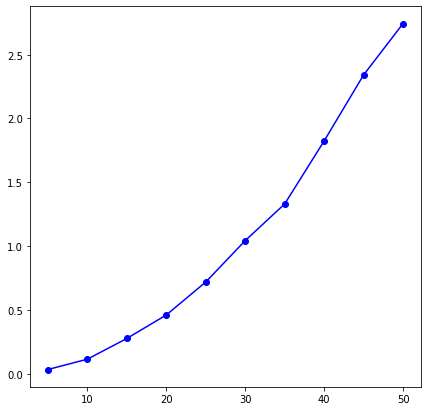

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
plt.plot(benchmark.loc["greedy"], "bo-")
plt.show()
benchmark.to_csv("../Dati/altro/benchmark.csv", sep=";", encoding = "ISO-8859-1")

In [ ]:
dfur1 = pd.DataFrame({})
dfur2 = pd.DataFrame({})

results = pd.DataFrame({}, index=["greedy"], columns=table.columns)

for d in table.columns:
    if d in ["lunedi", "venerdi"]:       
        l, _, t = greedy(table[d].dropna(), dft, d)
        dfur1 = pd.concat([dfur1, pd.DataFrame(pd.Series(l).rename(d))], axis=1)
        results[d]["greedy"]=(t, len(table[d].dropna()))
    else:
        l1, l2, t= greedy(table[d].dropna(), dft, d)
        results[d]["greedy"]=(t, len(table[d].dropna()))
        dfur1 = pd.concat([dfur1, pd.DataFrame(pd.Series(l1).rename(d))], axis=1)
        dfur2 = pd.concat([dfur2, pd.DataFrame(pd.Series(l2).rename(d))], axis=1)
print(results)

In [4]:
#dfur1.to_csv('../Dati/turni_f/fine_optimized_start/foss_greedy1.csv', index=False, sep=";", encoding = "ISO-8859-1")
#dfur2.to_csv('../Dati/turni_f/fine_optimized_start/foss_greedy2.csv', index=False, sep=";", encoding = "ISO-8859-1")

In [6]:
results.to_csv("../Dati/altro/computational_times_FOSS.csv", sep=";", encoding = "ISO-8859-1")